## Alibi Overview Example

This notebook aims to demonstrate each of the explainers Alibi provides on the same model and dataset. Unfortunately, this isn't possible as white-box neural network methods exclude tree-based white-box methods. Hence we will train both a tensorflow and a random forest model on the same dataset and apply the full range of explainers to see what insights we can obtain. 

In [1]:
import requests
from io import BytesIO, StringIO
from io import BytesIO
from zipfile import ZipFile

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
np.random.seed(0)

## Preparing the data.

We're using the [wine-quality](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/) dataset, a numeric tabular dataset containing features that refer to the chemical composition of wines and quality ratings. To make this a simple classification task, we bucket all wines with ratings greater than five as good, and the rest we label bad. As well as this we normalize all the features.

In [2]:
def fetch_wine_ds():
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'

    try:
        resp = requests.get(url, timeout=2)
        resp.raise_for_status()
    except requests.RequestException:
        logger.exception("Could not connect, URL may be out of service")
        raise
    string_io = StringIO(resp.content.decode('utf-8'))
    return pd.read_csv(string_io, sep=';')

In [3]:
df = fetch_wine_ds()

In [8]:
df['class'] = 'bad'
df.loc[(df['quality'] > 5), 'class'] = 'good'

features = [
    'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
    'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
    'pH', 'sulphates', 'alcohol'
]

df['good'] = 0
df['bad'] = 0
df.loc[df['class'] == 'good', 'good'] = 1
df.loc[df['class'] == 'bad', 'bad'] = 1

data = df[features].to_numpy()
labels = df[['class','good', 'bad']].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(data, labels, random_state=0)
X_train, X_test = X_train.astype('float32'), X_test.astype('float32')
y_train_lab, y_test_lab = y_train[:, 0], y_test[:, 0]
y_train, y_test = y_train[:, 1:].astype('float32'), y_test[:, 1:].astype('float32')

scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [15]:
df[features + ['class']]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,class
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,bad
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,bad
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,bad
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,good
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,bad
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,bad
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,good
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,good
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,bad


### Creating an Autoencoder

For some of the explainers, we need an autoencoder to check whether example instances are close to the training data distribution or not.

Text(0, 0.5, 'MSE-Loss')

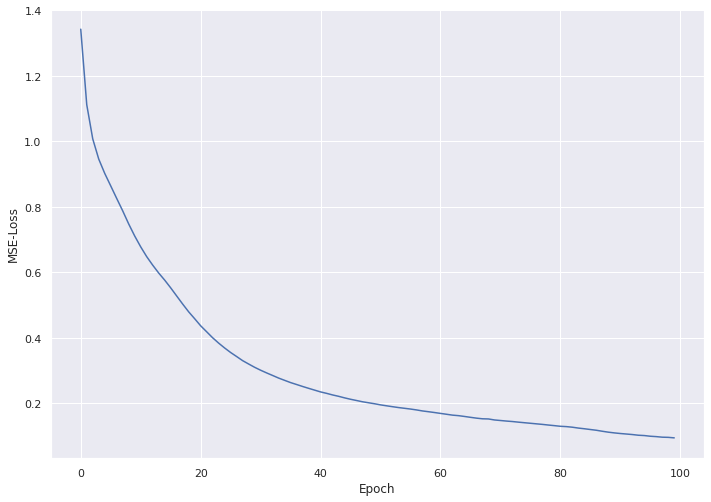

In [5]:
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import metrics, Input
from tensorflow import keras
import tensorflow as tf

ENCODING_DIM = 7
BATCH_SIZE = 64
EPOCHS = 100


class AE(keras.Model):
    def __init__(self, encoder: keras.Model, decoder: keras.Model, **kwargs) -> None:
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, x: tf.Tensor, **kwargs):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat
    
len_input_output = X_train.shape[-1]

encoder = keras.Sequential()
encoder.add(Dense(units=ENCODING_DIM*2, activation="relu", input_shape=(len_input_output, )))
encoder.add(Dense(units=ENCODING_DIM, activation="relu"))

decoder = keras.Sequential()
decoder.add(Dense(units=ENCODING_DIM*2, activation="relu", input_shape=(ENCODING_DIM, )))
decoder.add(Dense(units=len_input_output, activation="linear"))
    
ae = AE(encoder=encoder, decoder=decoder)
    
ae.compile(optimizer='adam', loss='mean_squared_error')
history = ae.fit(
    scaler.transform(X_train), 
    scaler.transform(X_train), 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS, 
    verbose=False,)

loss = history.history['loss']
plt.plot(loss)
plt.xlabel('Epoch')
plt.ylabel('MSE-Loss')

Later we'll use tensorflow version 1 as the counterfactual methods depend on this version of tensorflow. The easiest way to use a model built with tfv2 in tfv1 is to save and load it.

In [6]:
ae.encoder.save('wine_encoder.h5')
ae.decoder.save('wine_decoder.h5')

# Random Forest Model

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

rfc = RandomForestClassifier(n_estimators=50)
rfc.fit(scaler.transform(X_train), y_train_lab)
y_pred = rfc.predict(scaler.transform(X_test))

print('accuracy_score:', accuracy_score(y_pred, y_test_lab))
print('f1_score:', f1_score(y_test_lab, y_pred, average=None))

# disp = ConfusionMatrixDisplay(confusion_matrix(y_test_lab, y_pred), display_labels=rfc.classes_)
# disp.plot()

accuracy_score: 0.815
f1_score: [0.8        0.82790698]


# Tensorflow Model

In [8]:
from tensorflow import keras
from tensorflow.keras import layers 


inputs = keras.Input(shape=X_train.shape[1])
x = layers.Dense(6, activation="relu")(inputs)
outputs = layers.Dense(2, activation="softmax")(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])
history = model.fit(
    scaler.transform(X_train), 
    y_train,
    epochs=30, 
    verbose=False, 
    validation_data=(scaler.transform(X_test), y_test),
)

y_pred = model(scaler.transform(X_test)).numpy().argmax(axis=1)
print('accuracy_score:', accuracy_score(y_pred, y_test.argmax(axis=1)))
print('f1_score:', f1_score(y_pred, y_test.argmax(axis=1), average=None))

# disp = ConfusionMatrixDisplay(confusion_matrix(y_pred, y_test.argmax(axis=1)))
# disp.plot()

accuracy_score: 0.74
f1_score: [0.75471698 0.72340426]


# Select Instance 

We partition the dataset into good and bad portions and select an instance of interest.

In [9]:
bad_wines = np.array([a for a, b in zip(X_train, y_train) if b[1] == 1])
good_wines = np.array([a for a, b in zip(X_train, y_train) if b[1] == 0])

x = X_train[(model(X_train).numpy()[:, 0] > 0.7) & (model(X_train).numpy()[:, 0] < 0.9)][0][None]


# Util functions for visualizing and comparing instance differences

In [38]:
def plot_cf_and_feature_dist(x, cf, feature='total sulfur dioxide'):
    """
    Create a kde plot of feature distribution and plot counter factual and instance feature values.
    """
    ind = features.index(feature)
    ax = sns.kdeplot(bad_wines[:, ind], bw_method=0.5, c='r')
    sns.kdeplot(good_wines[:, ind], bw_method=0.5, c='b')
    plt.axvline(x=x[:, ind], c='b', alpha=0.4)
    plt.axvline(x=cf[:, ind], c='r', alpha=0.4) 
    plt.xticks([x[0, ind], cf[0, ind]], ['x', 'c'])
    plt.ylabel('Probability')
    plt.xlabel(' '.join([word.capitalize() for word in feature.split(' ')]))
    plt.show()


In [11]:
def compare_instances(x, cf):
    """
    Show the difference in values between two instances.
    """
    x = x.astype('float64')
    cf = cf.astype('float64')
    for f, v1, v2 in zip(features, x[0], cf[0]):
        print(f'{f:<25} instance: {round(v1, 3):^10} counter factual: {round(v2, 3):^10} difference: {round(v1 - v2, 7):^5}')


In [12]:
def plot_importance(feat_imp, feat_names, class_idx, **kwargs):
    """
    Create a horizontal barchart of feature effects, sorted by their magnitude.
    """
    
    df = pd.DataFrame(data=feat_imp, columns=feat_names).sort_values(by=0, axis='columns')
    feat_imp, feat_names = df.values[0], df.columns
    fig, ax = plt.subplots(figsize=(10, 5))
    y_pos = np.arange(len(feat_imp))
    ax.barh(y_pos, feat_imp)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(feat_names, fontsize=15)
    ax.invert_yaxis()
    ax.set_xlabel(f'Feature effects for class {class_idx}', fontsize=15)
    return ax, fig

## Integrated Gradients

We illustrate the apllication of integrated to the instance of interest

(<AxesSubplot:xlabel='Feature effects for class 0'>,
 <Figure size 720x360 with 1 Axes>)

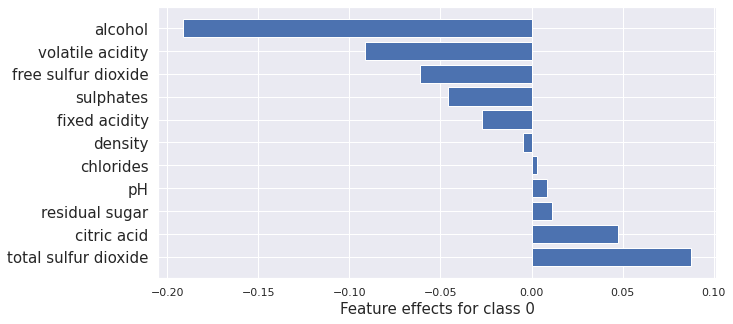

In [13]:
from alibi.explainers import IntegratedGradients

ig = IntegratedGradients(model,
                         layer=None,
                         method="gausslegendre",
                         n_steps=50,
                         internal_batch_size=100)

result = ig.explain(scaler.transform(x), target=0)

plot_importance(result.data['attributions'][0], features, 0)


## KernelSHAP

  0%|          | 0/1 [00:00<?, ?it/s]

(<AxesSubplot:xlabel='Feature effects for class 0'>,
 <Figure size 720x360 with 1 Axes>)

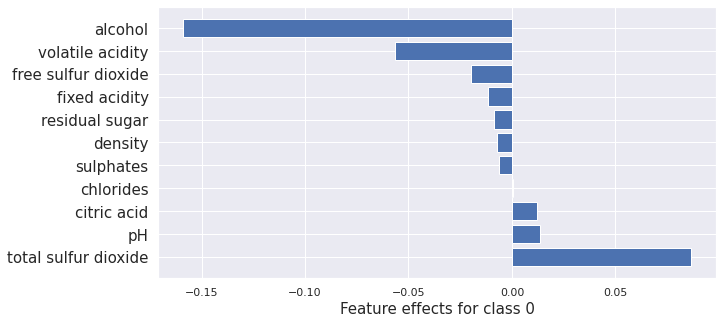

In [14]:
import shap
from alibi.explainers import KernelShap

predict_fn = lambda x: model(scaler.transform(x))

explainer = KernelShap(predict_fn, task='classification')

explainer.fit(X_train[0:100])

result = explainer.explain(x)

plot_importance(result.shap_values[0], features, 0)


  0%|          | 0/1 [00:00<?, ?it/s]

(<AxesSubplot:xlabel='Feature effects for class 1'>,
 <Figure size 720x360 with 1 Axes>)

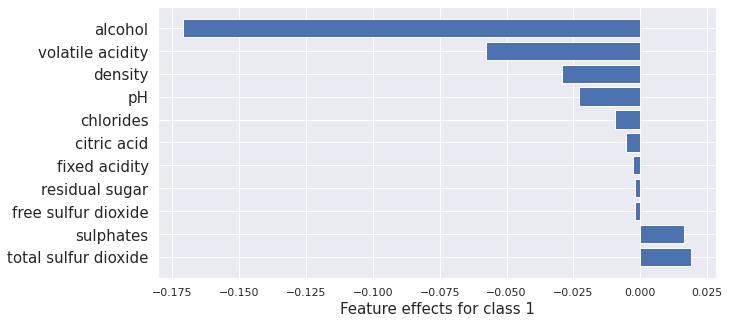

In [15]:
import shap
from alibi.explainers import KernelShap

predict_fn = lambda x: rfc.predict_proba(scaler.transform(x))

explainer = KernelShap(predict_fn, task='classification')

explainer.fit(X_train[0:100])

result = explainer.explain(x)

plot_importance(result.shap_values[1], features, 1)

## Interventional treeSHAP

(<AxesSubplot:xlabel='Feature effects for class 1'>,
 <Figure size 720x360 with 1 Axes>)

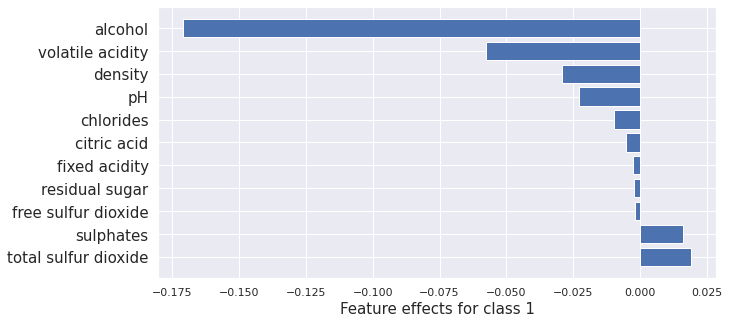

In [16]:
from alibi.explainers import TreeShap
import shap

tree_explainer_interventional = TreeShap(rfc, model_output='raw', task='classification')
tree_explainer_interventional.fit(scaler.transform(X_train[0:100]))
result = tree_explainer_interventional.explain(scaler.transform(x))

plot_importance(result.shap_values[1], features, 1)


## Path Dependent treeSHAP

(<AxesSubplot:xlabel='Feature effects for class 1'>,
 <Figure size 720x360 with 1 Axes>)

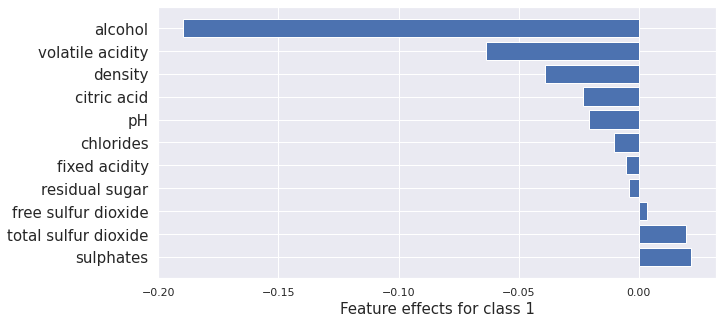

In [17]:
path_dependent_explainer = TreeShap(rfc, model_output='raw', task='classification')
path_dependent_explainer.fit()
result = path_dependent_explainer.explain(scaler.transform(x))

plot_importance(result.shap_values[1], features, 1)


## Anchors

In [42]:
from alibi.explainers import AnchorTabular

predict_fn = lambda x: model.predict(scaler.transform(x))
explainer = AnchorTabular(predict_fn, features)
explainer.fit(X_train, disc_perc=(25, 50, 75))
result = explainer.explain(scaler.inverse_transform(x), threshold=0.95)

In [43]:
print('Anchor =', result.data['anchor'])
print('Precision = ', result.data['precision'])
print('Coverage = ', result.data['coverage'])

Anchor = ['alcohol > 11.00', 'sulphates > 0.73']
Precision =  0.9931506849315068
Coverage =  0.0817347789824854


## ALE 

array([[<AxesSubplot:xlabel='alcohol', ylabel='ALE'>]], dtype=object)

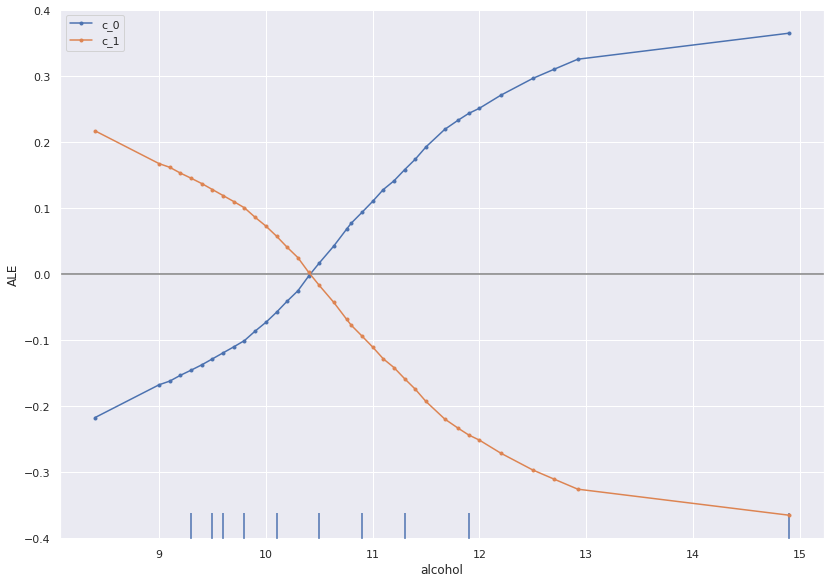

In [20]:
from alibi.explainers import ALE
from alibi.explainers import plot_ale

predict_fn = lambda x: model(scaler.transform(x)).numpy()
ale = ALE(predict_fn, feature_names=features)
exp = ale.explain(X_train)
plot_ale(exp, features=['alcohol'])

## Counter Factuals with Reinforcement Learning

In [21]:
from alibi.explainers import CounterfactualRL 

# Define constants
COEFF_SPARSITY = 7.5               # sparisty coefficient
COEFF_CONSISTENCY = 0              # consisteny coefficient -> no consistency
TRAIN_STEPS = 5000
# number of training steps -> consider increasing the number of steps
BATCH_SIZE = 100                   # batch size

predict_fn = lambda x: model(x)

explainer = CounterfactualRL(predictor=predict_fn,
                             encoder=ae.encoder,
                             decoder=ae.decoder,
                             latent_dim=ENCODING_DIM,
                             coeff_sparsity=COEFF_SPARSITY,
                             coeff_consistency=COEFF_CONSISTENCY,
                             train_steps=TRAIN_STEPS,
                             batch_size=BATCH_SIZE,
                             backend="tensorflow")

In [22]:
explainer.fit(X=scaler.transform(X_train))

100%|██████████| 5000/5000 [00:47<00:00, 104.47it/s]


CounterfactualRL(meta={
  'name': 'CounterfactualRL',
  'type': ['blackbox'],
  'explanations': ['local'],
  'params': {
              'act_noise': 0.1,
              'act_low': -1.0,
              'act_high': 1.0,
              'replay_buffer_size': 1000,
              'batch_size': 100,
              'num_workers': 4,
              'shuffle': True,
              'exploration_steps': 100,
              'update_every': 1,
              'update_after': 10,
              'train_steps': 5000,
              'backend': 'tensorflow',
              'encoder_preprocessor': 'identity_function',
              'decoder_inv_preprocessor': 'identity_function',
              'reward_func': 'get_classification_reward',
              'postprocessing_funcs': [],
              'conditional_func': 'generate_empty_condition',
              'callbacks': [],
              'actor': "<class 'alibi.models.tensorflow.actor_critic.Actor'>",
              'critic': "<class 'alibi.models.tensorflow.actor_critic.Cr

100%|██████████| 1/1 [00:00<00:00, 248.40it/s]


fixed acidity             instance:   7.856    counter factual:    7.8     difference: 0.0557041
volatile acidity          instance:   0.657    counter factual:    0.62    difference: 0.0365658
citric acid               instance:   0.099    counter factual:    0.05    difference: 0.0491835
residual sugar            instance:   2.075    counter factual:    2.3     difference: -0.2247791
chlorides                 instance:   0.061    counter factual:   0.079    difference: -0.0175778
free sulfur dioxide       instance:   10.058   counter factual:    6.0     difference: 4.0575562
total sulfur dioxide      instance:   24.849   counter factual:    18.0    difference: 6.8489075
density                   instance:   0.997    counter factual:   0.997    difference: -0.0001004
pH                        instance:   3.383    counter factual:    3.29    difference: 0.0931356
sulphates                 instance:   0.515    counter factual:    0.63    difference: -0.1146441
alcohol                   

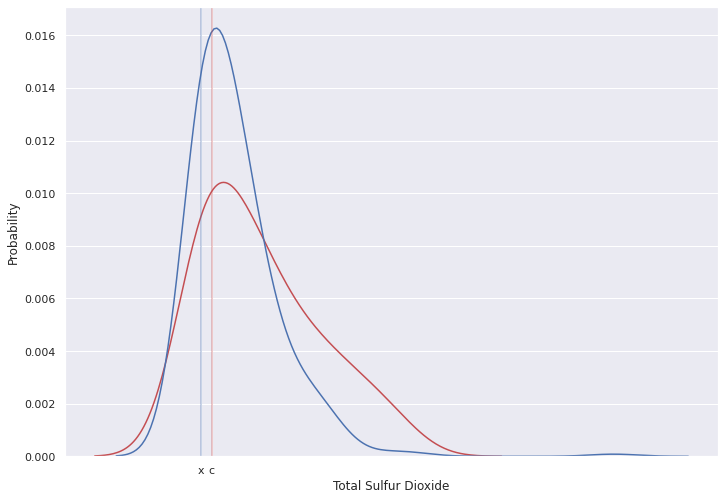

In [23]:
result_cfrl = explainer.explain(X=scaler.transform(x), Y_t=np.array([1]))
cfrl = scaler.inverse_transform(result_cfrl.data['cf']['X'])
compare_instances(cfrl, x)
plot_cf_and_feature_dist(x, cfrl, feature='total sulfur dioxide')

## Set up tfv1

In [24]:
model.save('wine_clf.h5')
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [25]:
from tensorflow.keras.models import Model, load_model
model = load_model('wine_clf.h5')

## Counterfactual Instances

In [64]:
from alibi.explainers import Counterfactual

shape = (1,) + X_train.shape[1:]
target_proba = 0.51
tol = 0.01 # want counterfactuals with p(class)>0.99
target_class = 'other'
max_iter = 1000
lam_init = 1e-1
max_lam_steps = 10
learning_rate_init = 0.1
feature_range = (scaler.transform(X_train).min(), scaler.transform(X_train).max())

explainer = Counterfactual(
    model,
    shape=shape, 
    target_proba=target_proba,
    tol=tol,
    target_class=target_class,
    max_iter=max_iter, 
    lam_init=lam_init,
    max_lam_steps=max_lam_steps,
    learning_rate_init=learning_rate_init,
    feature_range=feature_range
)

fixed acidity             instance:    7.8     counter factual:    7.84    difference: -0.0397391
volatile acidity          instance:    0.62    counter factual:   0.618    difference: 0.0020646
citric acid               instance:    0.05    counter factual:   0.049    difference: 0.0005868
residual sugar            instance:    2.3     counter factual:   2.273    difference: 0.0272591
chlorides                 instance:   0.079    counter factual:   0.079    difference: -2.49e-05
free sulfur dioxide       instance:    6.0     counter factual:   6.027    difference: -0.0270853
total sulfur dioxide      instance:    18.0    counter factual:   17.292   difference: 0.708271
density                   instance:   0.997    counter factual:   0.997    difference: -1.56e-05
pH                        instance:    3.29    counter factual:   3.282    difference: 0.0077941
sulphates                 instance:    0.63    counter factual:   0.712    difference: -0.0823232
alcohol                   in

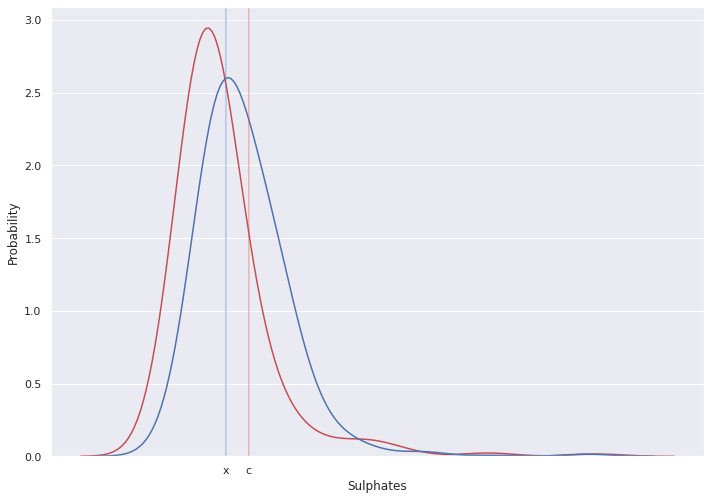

In [65]:
result_cf = explainer.explain(scaler.transform(x))
cf = result_cf.data['cf']['X']
cf = scaler.inverse_transform(cf)
compare_instances(x, cf)
plot_cf_and_feature_dist(x, cf, feature='sulphates')

In [66]:
print(model.predict(x))
print(model.predict(cf))


[[0.72949547 0.27050447]]
[[0.80257004 0.19742996]]


## Contrastive Explanations Method

In [28]:
from alibi.explainers import CEM

mode = 'PN'  # 'PN' (pertinent negative) or 'PP' (pertinent positive)
shape = (1,) + X_train.shape[1:]  # instance shape
kappa = .2  # minimum difference needed between the prediction probability for the perturbed instance on the
            # class predicted by the original instance and the max probability on the other classes
            # in order for the first loss term to be minimized
beta = .1  # weight of the L1 loss term
c_init = 10.  # initial weight c of the loss term encouraging to predict a different class (PN) or
              # the same class (PP) for the perturbed instance compared to the original instance to be explained
c_steps = 10  # nb of updates for c
max_iterations = 1000  # nb of iterations per value of c
feature_range = (scaler.transform(X_train).min(axis=0).reshape(shape)-.1,  # feature range for the perturbed instance
                 scaler.transform(X_train).max(axis=0).reshape(shape)+.1)  # can be either a float or array of shape (1xfeatures)
clip = (-1000.,1000.)  # grXdient clipping
lr_init = 1e-2  # initial learning rate

In [29]:
cem = CEM(model, mode, shape, kappa=kappa, beta=beta, feature_range=feature_range,
          max_iterations=max_iterations, c_init=c_init, c_steps=c_steps,
          learning_rate_init=lr_init, clip=clip)
cem.fit(scaler.transform(X_train), no_info_type='median')
result_cem = cem.explain(scaler.transform(x), verbose=False)

fixed acidity             instance:    7.8     counter factual:    7.8     difference:  0.0 
volatile acidity          instance:    0.62    counter factual:    0.62    difference:  0.0 
citric acid               instance:    0.05    counter factual:    0.05    difference:  0.0 
residual sugar            instance:    2.3     counter factual:    2.3     difference:  0.0 
chlorides                 instance:   0.079    counter factual:   0.079    difference:  0.0 
free sulfur dioxide       instance:    6.0     counter factual:    6.0     difference:  0.0 
total sulfur dioxide      instance:    18.0    counter factual:   17.107   difference: 0.8926582
density                   instance:   0.997    counter factual:   0.997    difference:  0.0 
pH                        instance:    3.29    counter factual:    3.29    difference:  0.0 
sulphates                 instance:    0.63    counter factual:   0.781    difference: -0.1507046
alcohol                   instance:    9.3     counter factua

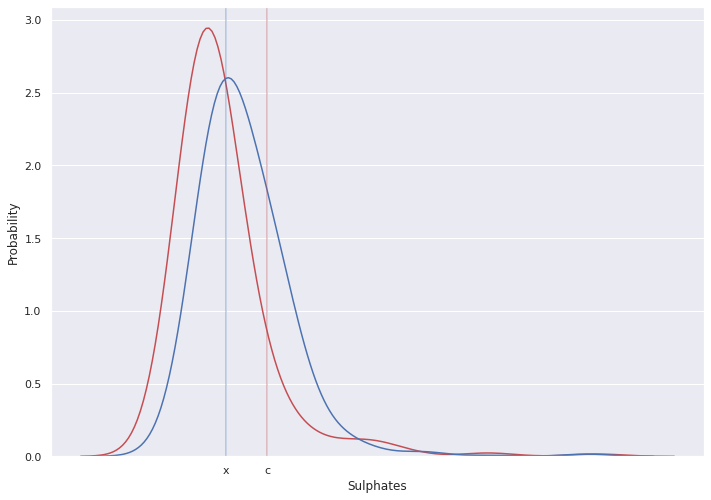

In [30]:
cem_cf = result_cem.data['PN']
cem_cf = scaler.inverse_transform(cem_cf)
compare_instances(x, cem_cf)
plot_cf_and_feature_dist(x, cem_cf, feature='sulphates')

## Counterfactual With Prototypes

In [31]:
encoder = load_model('wine_encoder.h5')
decoder = load_model('wine_decoder.h5')

In [32]:
from alibi.explainers import CounterfactualProto

ae = AE(encoder=encoder, decoder=decoder)

explainer = CounterfactualProto(
    model,
    shape=shape,
    ae_model=ae,
    enc_model=encoder,
    max_iterations=500,
    feature_range=feature_range,
    c_init=1., 
    c_steps=4,
    eps=(1e-2, 1e-2), 
    update_num_grad=100
)

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


In [33]:
explainer.fit(scaler.transform(X_train))
result_proto = explainer.explain(scaler.transform(x), Y=None, target_class=None, k=20, k_type='mean',
                                 threshold=0., verbose=False, print_every=100, log_every=100)

fixed acidity             instance:    7.8     counter factual:    7.8     difference:  0.0 
volatile acidity          instance:    0.62    counter factual:   0.594    difference: 0.0259061
citric acid               instance:    0.05    counter factual:    0.05    difference:  0.0 
residual sugar            instance:    2.3     counter factual:    2.3     difference:  0.0 
chlorides                 instance:   0.079    counter factual:   0.079    difference:  0.0 
free sulfur dioxide       instance:    6.0     counter factual:    6.0     difference:  0.0 
total sulfur dioxide      instance:    18.0    counter factual:    18.0    difference:  0.0 
density                   instance:   0.997    counter factual:   0.997    difference:  0.0 
pH                        instance:    3.29    counter factual:    3.29    difference:  0.0 
sulphates                 instance:    0.63    counter factual:   0.704    difference: -0.0743216
alcohol                   instance:    9.3     counter factua

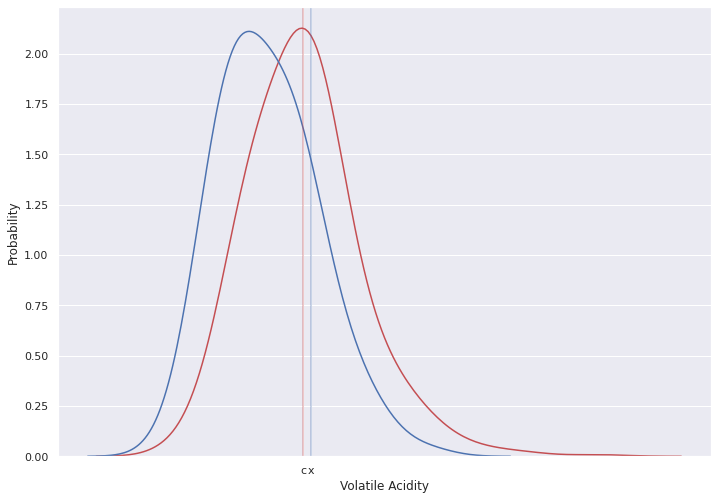

In [37]:
proto_cf = result_proto.data['cf']['X']
proto_cf = scaler.inverse_transform(proto_cf)
compare_instances(x, proto_cf)
plot_cf_and_feature_dist(x, proto_cf, feature='volatile acidity')

array([[0.72754335, 0.27245668]], dtype=float32)